In [241]:
# Import libraries
'''Main'''
import numpy as np # linear algebra
import pandas as pd # data processing
import re

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
import pickle, gzip
from sklearn import preprocessing as pp # impute missing values, normalize data, etc.
from scipy.stats import pearsonr # calculate correlation matrix
from numpy.testing import assert_array_almost_equal
from sklearn.model_selection import train_test_split # generate training and test sets
from sklearn.model_selection import StratifiedKFold # generate validation sets
from sklearn.metrics import log_loss # calculate log-loss (or cross entropy between the true labels and the predictions)
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report 
import time

'''Algos'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#import xgboost as xgb
import lightgbm as lgb

In [242]:
data = pd.read_csv('LoanStats3a.csv')

C:\Users\ankur\Anaconda3\envs\unsupervisedLearning\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [243]:
columnsToKeep = ['loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate','installment','grade','sub_grade',
                 'emp_length','home_ownership','annual_inc','verification_status','pymnt_plan',
                 'purpose','addr_state','dti','delinq_2yrs','earliest_cr_line',
                 'mths_since_last_delinq','mths_since_last_record','open_acc','pub_rec','revol_bal',
                 'revol_util','total_acc','initial_list_status','out_prncp','out_prncp_inv',
                 'total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee',
                 'recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt']
data = data.loc[:,columnsToKeep]

In [244]:
data.shape

(42542, 37)

In [245]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,...,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-15,171.62
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,...,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-13,119.66
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,...,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.00,Jun-14,649.91
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,...,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.00,Jan-15,357.48
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,...,0.0,4066.908161,4066.91,3000.00,1066.91,0.00,0.0,0.00,Jan-17,67.30


In [246]:
for i in ["term","int_rate","emp_length","revol_util"]:
    data.loc[:,i] = data.loc[:,i].apply(lambda x: re.sub("[^0-9]", "", str(x)))
    data.loc[:,i] = data.loc[:,i].convert_objects(convert_numeric=True)

C:\Users\ankur\Anaconda3\envs\unsupervisedLearning\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


In [247]:
numericalFeats = [x for x in data.columns if data[x].dtype != 'object']

In [248]:
nanCounter = np.isnan(data.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                      7
funded_amnt                    7
funded_amnt_inv                7
term                           7
int_rate                       7
installment                    7
emp_length                  1119
annual_inc                    11
dti                            7
delinq_2yrs                   36
mths_since_last_delinq     26933
mths_since_last_record     38891
open_acc                      36
pub_rec                       36
revol_bal                      7
revol_util                    97
total_acc                     36
out_prncp                      7
out_prncp_inv                  7
total_pymnt                    7
total_pymnt_inv                7
total_rec_prncp                7
total_rec_int                  7
total_rec_late_fee             7
recoveries                     7
collection_recovery_fee        7
last_pymnt_amnt                7
dtype: int64

In [249]:
fillWithMean = ['loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate','installment','emp_length',
               'annual_inc','dti','open_acc','revol_bal','revol_util','total_acc','out_prncp',
               'out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','last_pymnt_amnt']

fillWithZero = ['delinq_2yrs','mths_since_last_delinq','mths_since_last_record','pub_rec','total_rec_late_fee',
                'recoveries','collection_recovery_fee']

im = pp.Imputer(strategy='mean')   
data.loc[:,fillWithMean] = im.fit_transform(data[fillWithMean])

data.loc[:,fillWithZero] = data.loc[:,fillWithZero].fillna(value=0,axis=1)

In [250]:
nanCounter = np.isnan(data.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
emp_length                 0
annual_inc                 0
dti                        0
delinq_2yrs                0
mths_since_last_delinq     0
mths_since_last_record     0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_int              0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
last_pymnt_amnt            0
dtype: int64

In [264]:
data['installmentOverLoanAmnt'] = data.installment/data.loan_amnt
data['loanAmntOverIncome'] = data.loan_amnt/data.annual_inc
data['revol_balOverIncome'] = data.revol_bal/data.annual_inc
data['totalPymntOverIncome'] = data.total_pymnt/data.annual_inc
data['totalPymntInvOverIncome'] = data.total_pymnt_inv/data.annual_inc
data['totalRecPrncpOverIncome'] = data.total_rec_prncp/data.annual_inc
data['totalRecIncOverIncome'] = data.total_rec_int/data.annual_inc

newFeats = ['installmentOverLoanAmnt','loanAmntOverIncome','revol_balOverIncome','totalPymntOverIncome',
           'totalPymntInvOverIncome','totalRecPrncpOverIncome','totalRecIncOverIncome']

In [265]:
numericalPlusNewFeats = numericalFeats+newFeats
X_train = data.loc[:,numericalPlusNewFeats]

sX = pp.StandardScaler()
X_train.loc[:,:] = sX.fit_transform(X_train)

In [268]:
X_train.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'installmentOverLoanAmnt',
       'loanAmntOverIncome', 'revol_balOverIncome', 'totalPymntOverIncome',
       'totalPymntInvOverIncome', 'totalRecPrncpOverIncome',
       'totalRecIncOverIncome'],
      dtype='object')

In [253]:
labels = data.grade
labels.unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G', nan], dtype=object)

In [254]:
labels = labels.fillna(value="Z")

lbl = pp.LabelEncoder()
lbl.fit(list(labels.values))
labels = pd.Series(data=lbl.transform(labels.values), name="grade")

y_train = labels

In [259]:
labelsOriginalVSNew = pd.concat([labels, data.grade],axis=1)
labelsOriginalVSNew

,grade,grade
0,1,B
1,2,C
2,2,C
3,2,C
4,1,B
5,0,A
6,2,C
7,4,E
8,5,F
9,1,B


In [261]:
interestAndGrade = pd.DataFrame(data=[data.int_rate,labels])
interestAndGrade = interestAndGrade.T

interestAndGrade.groupby("grade").mean()

,int_rate
grade,
0.0,734.270844
1.0,1101.420857
2.0,1349.988902
3.0,1557.714927
4.0,1737.676783
5.0,1926.530361
6.0,2045.125000
7.0,1216.501563


In [42]:
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount']
        
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
        
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg(lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster,left_on="cluster",right_on="cluster")
    overallAccuracy = accuracyDF.countMostFrequent.sum()/accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent/accuracyDF.clusterCount
    return countByCluster, countByLabel, countMostFreq, accuracyDF, overallAccuracy, accuracyByLabel

In [269]:
from sklearn.cluster import KMeans

n_clusters = 10
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter,
               tol=tol, random_state=random_state, n_jobs=n_jobs)

kMeans_inertia = pd.DataFrame(data=[],index=range(10,31),columns=['inertia'])
overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=range(10,31),columns=['overallAccuracy'])

for n_clusters in range(10,31):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter,
                   tol=tol, random_state=random_state, n_jobs=n_jobs)

    kmeans.fit(X_train)
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train)
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, index=X_train.index, 
                                           columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans = analyzeCluster(X_train_kmeansClustered, y_train)
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans

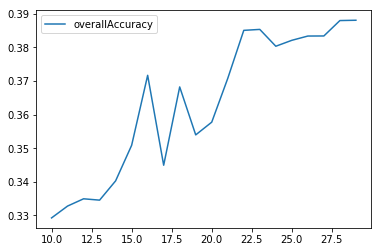

In [319]:
overallAccuracy_kMeansDF.plot()

In [273]:
accuracyByLabel_kMeans

0     0.346732
1     0.351541
2     0.259346
3     0.333333
4     0.714146
5     0.266667
6     0.327044
7     0.359031
8     0.332016
9     0.393398
10    0.323317
11    0.291809
12    0.486352
13    0.586883
14    0.250000
15    0.202899
16    0.275919
17    0.287247
18    0.345794
19    0.250000
20    0.228669
21    0.301887
22    0.281690
23    0.392650
24    0.500000
25    0.301205
26    0.264368
27    0.313220
28    0.240506
dtype: float64

In [277]:
import fastcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

Z = fastcluster.linkage_vector(X_train, method='ward', metric='euclidean')
Z_dataFrame = pd.DataFrame(data=Z,columns=['clusterOne','clusterTwo','distance','newClusterSize'])

In [314]:
Z_dataFrame

,clusterOne,clusterTwo,distance,newClusterSize
0,39786.0,39787.0,0.000000e+00,2.0
1,39788.0,42542.0,0.000000e+00,3.0
2,42538.0,42539.0,0.000000e+00,2.0
3,42540.0,42544.0,0.000000e+00,3.0
4,42541.0,42545.0,3.399350e-17,4.0
5,42543.0,42546.0,5.139334e-17,7.0
6,33251.0,33261.0,1.561313e-01,2.0
7,42512.0,42535.0,3.342654e-01,2.0
8,42219.0,42316.0,3.368231e-01,2.0
9,6112.0,21928.0,3.384368e-01,2.0


In [315]:
from scipy.cluster.hierarchy import fcluster
distance_threshold = 100
clusters = fcluster(Z, distance_threshold, criterion='distance')
X_train_hierClustered = pd.DataFrame(data=clusters,index=X_train_PCA.index,columns=['cluster'])

In [320]:
print("Number of distinct clusters: ",len(X_train_hierClustered['cluster'].unique()))

Number of distinct clusters:  32


In [321]:
countByCluster_hierClust, countByLabel_hierClust, countMostFreq_hierClust, accuracyDF_hierClust, overallAccuracy_hierClust, accuracyByLabel_hierClust = analyzeCluster(X_train_hierClustered, y_train)
print("Overall accuracy from hierarchical clustering: ",overallAccuracy_hierClust)

Overall accuracy from hierarchical clustering:  0.3651685393258427


In [323]:
print("Accuracy by cluster for hierarchical clustering")
accuracyByLabel_hierClust

Accuracy by cluster for hierarchical clustering


0     0.304124
1     0.219001
2     0.228311
3     0.379722
4     0.240064
5     0.272011
6     0.314560
7     0.263930
8     0.246138
9     0.318942
10    0.302752
11    0.269772
12    0.335717
13    0.330403
14    0.346320
15    0.440141
16    0.744155
17    0.502227
18    0.294118
19    0.236111
20    0.254727
21    0.241042
22    0.317979
23    0.308771
24    0.284314
25    0.243243
26    0.500000
27    0.289157
28    0.365283
29    0.479693
30    0.393559
31    0.340875
dtype: float64

In [329]:
from sklearn.cluster import DBSCAN

eps = 10
min_samples = 5
leaf_size = 30
n_jobs = 4

db = DBSCAN(eps=eps, min_samples=min_samples, leaf_size=leaf_size, 
            n_jobs=n_jobs)

X_train_dbscanClustered = db.fit_predict(X_train)
X_train_dbscanClustered = pd.DataFrame(data=X_train, index=X_train.index, columns=['cluster'])

countByCluster_dbscan, countByLabel_dbscan, countMostFreq_dbscan, accuracyDF_dbscan, overallAccuracy_dbscan, accuracyByLabel_dbscan = analyzeCluster(X_train_dbscanClustered, y_train)
overallAccuracy_dbscan

C:\Users\ankur\Anaconda3\envs\unsupervisedLearning\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


nan

In [330]:
print("Overall accuracy from DBSCAN: ",overallAccuracy_dbscan)

Overall accuracy from DBSCAN:  nan


In [331]:
print("Cluster results for DBSCAN")
countByCluster_dbscan

Cluster results for DBSCAN


,cluster,clusterCount


In [328]:
X_train_dbscanClustered

,cluster
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


In [364]:
import hdbscan

min_cluster_size = 20
min_samples = 20
alpha = 1.0
cluster_selection_method = 'leaf'

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, alpha=alpha, cluster_selection_method=cluster_selection_method)

X_train_hdbscanClustered = hdb.fit_predict(X_train)
X_train_hdbscanClustered = pd.DataFrame(data=X_train_hdbscanClustered, index=X_train.index, columns=['cluster'])

countByCluster_hdbscan, countByLabel_hdbscan, countMostFreq_hdbscan, accuracyDF_hdbscan, overallAccuracy_hdbscan, accuracyByLabel_hdbscan = analyzeCluster(X_train_hdbscanClustered, y_train)

In [365]:
print("Overall accuracy from HDBSCAN: ",overallAccuracy_hdbscan)

Overall accuracy from HDBSCAN:  0.3246203751586667


In [366]:
print("Cluster results for HDBSCAN")
countByCluster_hdbscan

Cluster results for HDBSCAN


,cluster,clusterCount
0,-1,32708
1,7,4070
2,2,3668
3,1,1096
4,4,773
5,0,120
6,6,49
7,3,38
8,5,20


In [367]:
accuracyByLabel_hdbscan

0    0.284487
1    0.341667
2    0.414234
3    0.332061
4    0.552632
5    0.438551
6    0.400000
7    0.408163
8    0.590663
dtype: float64